# Imports


This first section will cover all necessary imports and the ordinor package installation.

To be able to execute the code from the paper you will need to install a development version of the ordinor package as a local dependency which we have included in our folder structure. The installation of the development branch directly from GitHub didn't work for us which is why we decided to install it locally. To install this get your currenct path of the "OrdinoR-dev" folder, open a terminal and run the following code snippet: 

In [3]:
#insert your local path to the OrdinoR-dev folder and run this cell
!pip install -e <path_to_ordinor>

Note: you may need to restart the kernel to use updated packages.


The syntax of the command is incorrect.


In [1]:
# import all required packages
import pm4py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from pytz import timezone
from collections import defaultdict
from tree import TreeNode, TreePrinter
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from ordinor.execution_context.rule_based import ODTMiner
from ordinor.execution_context.rule_based.Rule import Rule
from ordinor.execution_context.rule_based.TreeNode import Node

# Preprocessing

We used the pre-filtered data set BPIC 2019 that was used last semester in Process Management and Analytics. A lot less preprocessing is required for this data set, as no time differences have to be replicated.

In [5]:
# read the file and convert to csv
combined_df = pm4py.read_xes('data/raw/BPI_Challenge_2019-3-w-after.xes') 
combined_df.to_csv("data/raw/bpic19.csv", index=False)

c:\Users\corde\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/15182 [00:00<?, ?it/s]

## Modify authors preprocessing code to fit new data set and execute it


In [14]:
# Load raw data & Preprocess DataFrame (enrich with derived attributes)
# the following use of AT, CT, TT was used similar to the specification by the author an refers to the "Activity type", "Case type" and "Time type" described in the paper

logs = ['bpic19']

for log in logs:
    fn = f'data/raw/{log}.csv'
    df = pd.read_csv(fn)[[
         'case:concept:name', 'concept:name', 'case:(case) Item Type', 'time:timestamp', 'User'
    ]]
    
    # rename for better readability
    df = df.rename(columns={
        # TT-related
        "time:timestamp": "Complete Timestamp",
        # CT-related
        'case:(case) Item Type':'Item Type',
        # AT-related
        "concept:name": "Activity",
        # Additional
        "case:concept:name": "Case ID"
    })
    
    # define attributes for case type and activity type
    df = df[~df['Item Type'].isna()]
    df['ct:item_type'] = df['Item Type'] # Item Type is used as case type as it was a finding in the group project in "Process Management & Analytics" that this attribute influences the process to a great extent
    df['at:phase'] = df['Activity'] # no phases used, only "raw" activities because no domain knowledge of grouping present
    df = df[~df['Activity'].isna()]

    # derive and append TT related candidate attributes (month and day not used with original dataset, so also excluded here)
    df['Complete Timestamp'] = pd.to_datetime(
        df['Complete Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    #MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    #            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    #df['tt:month'] = df['Complete Timestamp'].apply(lambda ts: MONTHS[ts.month-1])
    #df['tt:day'] = df['Complete Timestamp'].apply(
     #   lambda ts: 'Day_{}'.format(ts.day))
    WEEKDAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    df['tt:weekday'] = df['Complete Timestamp'].apply(
        lambda ts: WEEKDAYS[ts.weekday()])
    df['tt:ampm'] = df['Complete Timestamp'].apply(
        lambda ts: 'AM' if ts.hour < 12 else 'PM')

    print(df)
    df.to_csv(f'data/processed/{log}.csv')

                 Case ID                    Activity Item Type  \
0       2000000001_00001                SRM: Created   Service   
1       2000000001_00001               SRM: Complete   Service   
2       2000000001_00001      SRM: Awaiting Approval   Service   
3       2000000001_00001     SRM: Document Completed   Service   
4       2000000001_00001                SRM: Ordered   Service   
...                  ...                         ...       ...   
319228  4508075963_00001  Record Service Entry Sheet   Service   
319229  4508075963_00001  Record Service Entry Sheet   Service   
319230  4508075963_00001  Record Service Entry Sheet   Service   
319231  4508075963_00001        Record Goods Receipt   Service   
319232  4508075963_00001        Record Goods Receipt   Service   

              Complete Timestamp      User ct:item_type  \
0      2018-01-03 08:49:00+00:00  batch_00      Service   
1      2018-01-03 09:49:00+00:00  batch_00      Service   
2      2018-01-03 09:49:00+00:

# Execution of ODT(Oblivious Decision Tree)-Miner

In this section the ODT-Miner gets executed for the new dataset.

In [17]:
# define a fucntion to train the miner
def trainMiners(tree_height):
    # train miner based on the orignal data
    df_bpic19 = pd.read_csv('data/processed/bpic19.csv')
    
    df_bpic19 = df_bpic19.rename(columns={
        # Resource-related
        "User": "org:resource",
        # TT-related
        "Complete Timestamp": "time:timestamp",
        # CT-related
        'Item Type': 'ct:last_phase',
        # AT-related
        "Activity": "concept:name",
        # Additional
        "Case ID": "case:concept:name"
    })
    
    spec = {
        'type_def_attrs': {
            # BPIC19
            'ct:item_type': {'attr_type': 'categorical', 'attr_dim': 'CT'},
            'at:phase': {'attr_type': 'categorical', 'attr_dim': 'AT'},
            'tt:weekday': {'attr_type': 'categorical', 'attr_dim': 'TT'},
            'tt:ampm': {'attr_type': 'categorical', 'attr_dim': 'TT'},
        }
    }

    # training the miner
    miner_bpic19 = ODTMiner(df_bpic19, spec, max_height=tree_height, trace_history=True)

    return miner_bpic19


miner_bpic19 = trainMiners(tree_height=7)





C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._log = el[included_cols]
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._log[const.RESOURCE] = self._log[const.RESOURCE].astype('category')
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:50: SettingWithCopyWarning: 
A value is trying to be se

Decision tree initialized with an empty root node
	Dis. = 0.000000, Imp. = 1.000000, Harmonic Mean. = 0.000000, *** Tree has 1 leaf node(s). ***
Start to fit decision tree with max. height = 7
Tree grows by splitting all current leaf nodes on `ct:item_type`, step=1 (running for 00:00:54s)
	Dis. = 0.001436, Imp. = 0.986440, Harmonic Mean. = 0.002869, *** Tree has 2 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=2 (running for 00:01:49s)
	Dis. = 0.006566, Imp. = 0.958355, Harmonic Mean. = 0.013044, *** Tree has 4 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=3 (running for 00:03:16s)
	Dis. = 0.010063, Imp. = 0.955577, Harmonic Mean. = 0.019917, *** Tree has 6 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=4 (running for 00:04:39s)
	Dis. = 0.012695, Imp. = 0.682189, Harmonic Mean. = 0.024925, *** Tree has 9 leaf node(s). ***
Tree grows by splitting all current leaf nodes on

The learned execution contexts have to be added again for the clustering algorithm.


In [18]:
def addDimensions(df, miner):
    # get different rules
    l_rules_ct, l_rules_at, l_rules_tt = miner._parse_rules_from_leaves(
        miner._leaves)

    # label ATs
    dfs = [r.apply(df, index_only=False).assign(AT_rule=r) for r in l_rules_at]
    df = pd.concat(dfs)

    # label CTs
    dfs = [r.apply(df, index_only=False).assign(CT_rule=r) for r in l_rules_ct]
    df = pd.concat(dfs)

    # label TTs
    dfs = [r.apply(df, index_only=False).assign(TT_rule=r) for r in l_rules_tt]
    df = pd.concat(dfs)

    # add CO_rule as combination of AT CT and TT
    df['CO_rule'] = df.apply(lambda x: Rule(x['AT_rule'].ars+x['CT_rule'].ars+x['TT_rule'].ars), axis=1)

    return df


# have to train miner again because i could not save the trained miners and the miners are changed by the last function
miner_bpic19 = trainMiners(tree_height=7) 

df_bpic19 = pd.read_csv('data/processed/bpic19.csv')
df_bpic19 = addDimensions(df_bpic19, miner_bpic19)
df_bpic19.to_csv('data/added_execution_contexts/bpic19.csv', index=False)



C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._log = el[included_cols]
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._log[const.RESOURCE] = self._log[const.RESOURCE].astype('category')
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:50: SettingWithCopyWarning: 
A value is trying to be se

Decision tree initialized with an empty root node
	Dis. = 0.000000, Imp. = 1.000000, Harmonic Mean. = 0.000000, *** Tree has 1 leaf node(s). ***
Start to fit decision tree with max. height = 7
Tree grows by splitting all current leaf nodes on `ct:item_type`, step=1 (running for 00:01:05s)
	Dis. = 0.001436, Imp. = 0.986440, Harmonic Mean. = 0.002869, *** Tree has 2 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=2 (running for 00:02:12s)
	Dis. = 0.009194, Imp. = 0.710548, Harmonic Mean. = 0.018153, *** Tree has 4 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=3 (running for 00:04:22s)
	Dis. = 0.009194, Imp. = 0.686532, Harmonic Mean. = 0.018145, *** Tree has 5 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=4 (running for 00:05:56s)
	Dis. = 0.009194, Imp. = 0.685934, Harmonic Mean. = 0.018144, *** Tree has 6 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `

# Results of replication

This section will now cover what we have achieved and which deifferences exist. The goal of this paper was to create execution contexts which should be used to form culsters more effiecently than just using the acticity itself. To show his success, the author draws a graph which compares the silouhette scores, depending on the number of clusters. There you can see his generated execution contexts generally form better clusters than just using the activity. We did the same for the new data set.

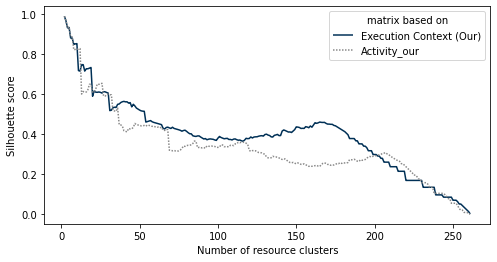

In [20]:

# create scores to show in graph
df = pd.read_csv('data/added_execution_contexts/bpic19.csv')

X1 = df.groupby(['User', 'Activity']).size().unstack().fillna(0) # grouping with attribute activity like in the original method
X2 = df.groupby(['User', 'CO_rule']).size().unstack().fillna(0) # using execution context

l_ss1 = []
l_ss2 = []
for k in range(2, len(X1)):
    clu1 = AgglomerativeClustering(n_clusters=k).fit_predict(X1)
    ss1 = silhouette_score(X1, clu1)
    l_ss1.append(ss1)
    clu2 = AgglomerativeClustering(n_clusters=k).fit_predict(X2)
    ss2 = silhouette_score(X2, clu2)
    l_ss2.append(ss2)
    
data = []

for i in range(len(l_ss1)):
    data.append({'k': i + 2, 'score': l_ss2[i], 'matrix based on': 'Execution Context (Our)'})
    data.append({'k': i + 2, 'score': l_ss1[i], 'matrix based on': 'Activity'}) 

data = pd.DataFrame(data)

data

f, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(data=data, x="k", y="score", ax=ax,
                  hue="matrix based on", style='matrix based on', 
                  palette={
                        'Activity': '#898989',
                        'Execution Context': '#003056'}, 
                    dashes={
                            'Activity': (1,1),
                            'Execution Context': (1, 0)})
plt.xlabel('Number of resource clusters')
plt.ylabel("Silhouette score")
plt.show()
f.savefig("graphs/omm_all.pdf", bbox_inches='tight')
